# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs)

## Problem 0 (45 points)

In this problem, you'll implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [1]:
from scipy.integrate import solve_ivp
from euler import ForwardEuler

%load_ext autoreload
%autoreload 2

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

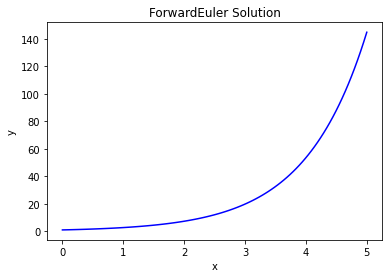

The largest error between ForwardEuler and the Sympy ground truth solution is: 3.6403866699945127
The largest error between ForwardEuler and the default solve_ivp is: 3.6216363044061097


In [7]:
import numpy as np
import sympy as sym
from sympy.solvers import ode
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Defining initial condition and the function
y0 = np.array([1])
f = lambda t, y : y

# Time interval
t_span = (0, 5)
t_eval = np.linspace(0, 5, 100)

# Solve IVP using the ForwardEuler method
sol1 = solve_ivp(f, t_span, y0, method = ForwardEuler, h=0.01, t_eval=t_eval)

# Plot y vs t 
plt.plot(sol1.t, sol1.y, c='b')
plt.title("ForwardEuler Solution")
plt.ylabel("y")
plt.xlabel("x")
plt.show()
        
# Symbolic Method
t = sym.symbols('t') # symbol
y = sym.Function('y') # symbolic function
eqn = y(t).diff(t) - y(t) # eqn = 0

# Solve IVP using symbolic dsolve
sol2 = ode.dsolve(eqn, hint='separable', ics={y(0): 1})

# Lamdifying the RHS of solution to be our function y
g = sym.lambdify(t, sol2.rhs, 'numpy')

# Calculating the y values for the same time interval
sol2y = g(np.array(np.linspace(0,5,100)))

# Find the largest error on the domain
print("The largest error between ForwardEuler and the Sympy ground truth solution is:", max(np.abs(sol2y - sol1.y)))



# Solve_ivp using default method
sol3 = solve_ivp(f, t_span, y0, t_eval=t_eval)

# Find the largest error on the domain
print("The largest error between ForwardEuler and the default solve_ivp is:", max(np.abs(sol3.y[0] - sol1.y)))


### Part C (15 points)

Implement unit tests that verify that ODE solutions (numerically) obey the ODE.  Try this for $y'(t) = y$, with $y(0) = 1$ on the domain $t\in [0,5]$.  Use a finite difference stencil with step size `k` (`k` should be smaller than the `h` you used to solve the ODE) to compute the derivative at several points.  You should only expect the derivative to be accurate to about `h*y`

Implement tests for `solve_ivp` using the default settings as well as using your `ForwardEuler` implementation.

Put these tests in [`test.py`](test.py).  Set up your unit tests to run when you push changes to GitHub using GitHub actions.

---

*put any discussion here*

In [8]:
# Attempt 1
import scipy.sparse as sparse
import scipy.linalg as sla


# Finite Difference Matrix Solution
y0 = 1
k = 0.005

def backward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(1,n):
        i.append(k)
        j.append(k)
        data.append(1)

        i.append(k)
        j.append(k-1)
        data.append(-1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

# Derivative matrix
Db = backward_diff_matrix(100) / k

# Identity
iden = np.eye(100)

# LHS of the equation D @ y - I @ y = 0
lhs = Db - iden

# Initial condition (wasn't sure when I should have added this but adding it before the previous subtraction
# caused the lhs matrix to be singular and I would get an error)
lhs[0,0] = 1

# Zeros vector for the RHS of the equation
zero = np.zeros(100)


# Solving the system (D - eye) @ y = 0
y = sla.solve(lhs, zero)


# ForwardEuler Solution
h = 0.01
y0 = np.array([1])
f = lambda t, y : y

t_span = (0, 5)
t_eval = np.linspace(0, 5, 100)

euler_sol = solve_ivp(f, t_span, y0, method = ForwardEuler, h=0.01, t_eval=t_eval)

# Comparing the two y values according to h*y
print(np.abs(y - euler_sol.y) < h*y)


# Of course I can tell the answer is wrong. I keep getting y = 0 for all entries and I have no idea why or what to do.
# I've been working on this almost all day and I'm really tired

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


/home/tokateid/jupyter_env/jupyter_env/lib/python3.8/site-packages/scipy/interpolate/polyint.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  yi = np.asarray(yi)
/home/tokateid/jupyter_env/jupyter_env/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:453: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = array(y, copy=self.copy)


In [9]:
# Attempt 2
import matplotlib.pyplot as plt
import sympy as sym
import numpy as np

# Symbolic Solution of ODE
t = sym.symbols('t') # symbol
y = sym.Function('y') # symbolic function
eqn = y(t).diff(t) - y(t) # eqn = 0
sol = ode.dsolve(eqn, hint='separable', ics={y(0): 1})
g = sym.lambdify(t, sol.rhs, 'numpy')


# Finite Difference Matrix Solution
y0 = 1
k = 0.005

def backward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(1,n):
        i.append(k)
        j.append(k)
        data.append(1)

        i.append(k)
        j.append(k-1)
        data.append(-1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()


# Derivative Matrix
D = backward_diff_matrix(100) / k
# Initial condition
D[0,0] = 1


# Euler Solution
y0 = np.array([1])
f = lambda t, y : y

t_span = (0, 5)
t_eval = np.linspace(0, 5, 100)

# Solution using ForwardEuler
euler_sol = solve_ivp(f, t_span, y0, method = ForwardEuler, h=0.01, t_eval=t_eval)

# Solution using Sympy (y values using the symbolic equation)
sym_y = g(euler_sol.t)

# Applying the derivative matrix (operator) to the symbolic solution
finite_diff_y = D @ sym_y

h = 0.01

# Comparing the two y values according to h*y
print(np.abs(finite_diff_y - euler_sol.y) < h*sym_y)


# Again This is also very wrong. At least the solution here isn't y=0 like attempt 1, but the values in y are 10x
# the true values and I'm not sure why. I tried figuring out where this factor of 10 could be coming from but didn't find
# anything so I don't know. 

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


/home/tokateid/jupyter_env/jupyter_env/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## Problem 1 (20 points)

In this problem, you'll solve two simple, but related, ODEs using `solve_ivp`.

### Part A (13 points)

On the surface of the earth, objects are accelerated by a more-or-less constant gravitational field.  We'll consider an object thrown vertically with initial position $y=y_0$, and initial velocity $y' = v_0$.

We'll consider a simplified problem with no wind resistance.  Newton's laws of motion tell us $y''(t) = -g$, where $g = 9.8 m/s^2$.  This is a second order ODE, which we can turn into a system of first order ODEs using the substituion $p = y'$.  Then we have
\begin{equation}
\begin{cases}
y'(t) = p(t)\\
p'(t) = -g
\end{cases}
\end{equation}

You can encode this using a vector $v$, where $v[0]$ is the value $y$ above, and $v[1]$ is $p$.

Use `solve_ivp` to solve for `y(t)` using `y0 = 0` and `y'(0) = 10` (i.e. you throw a ball straight up in the air at a speed of $10 m/s$).  Run this simulation for $4$ seconds.  make a plot of the trajectory $y$ as a function of $t$ (i.e. $t$ is on the horizontal axis and $y$ is on the vertical axis).  Set up an event to end the simulation when `y` is zero again (when the ball hits the ground).  At what time does the ball hit the ground?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

Time when the ball hits the ground again is: [2.04081633]
Time when the ball is at its highest point is: [1.02040816]


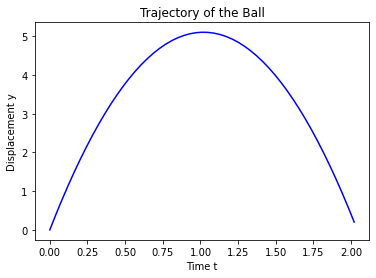

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Initial conditions and Parameters
y0 = 0
p0 = 10
g = 9.8
v0 = np.array([y0, p0])

# Defining the two first order ODEs
f = lambda t, y : np.array([y[1], -g] )

# Time interval
t_span = (0, 4)
t_eval = np.linspace(0, 4, 100)

# Define the event when ball hits the ground
def hit_ground(t, y): 
    return y[0] # = 0

hit_ground.terminal=True
hit_ground.direction=-1

# Define the event when ball reaches its peak
def peak(t, y):
    return y[1] # = 0

# Solve IVP with required events
sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=(hit_ground, peak))

# Finding the time when both events happen
print("Time when the ball hits the ground again is:", sol.t_events[0])
print("Time when the ball is at its highest point is:", sol.t_events[1])
    
# Plot the trajectory of the ball    
plt.plot(sol.t, sol.y[0], c='b')
plt.title("Trajectory of the Ball")
plt.ylabel("Displacement y")
plt.xlabel("Time t")
plt.show()

### Part B (7 points)

We'll now take into account wind resistance on the ball.  We'll make a bunch of assumptions, and simply assume that the drag can be expressed as a force that accelerates the ball by adding a term `y''(t) = p'(t) = -9.8 -0.02 sgn(p(t)) p(t)**2`, where `sgn(p(t))` can be computed using `np.sign` (the sign of the velocity).

Incorporate this term into the system of ODEs, and use `solve_ivp` to plot the trajectory of the ball with the same initial conditions as in part A.  Set up an event to terminate the simulation when the ball hits the ground.  At what time does the ball hit the ground?  Is this before or after the ball hits the ground when there is no wind resistance?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

Time when the ball hits the ground again is: [1.947363]
Time when the ball is at its highest point is: [0.95873405]


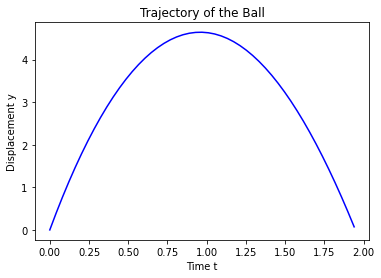

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Initial condition and parameters
y0 = 0
p0 = 10
g = 9.8
a = 0.02
v0 = np.array([y0, p0])

# Defining the first order ODEs with wind resistance term
f = lambda t, y : np.array([y[1], -g - a*np.sign(y[1])*y[1]**2] )

# Time interval
t_span = (0, 4)
t_eval = np.linspace(0, 4, 100)

# Defining event when ball hits the ground
def hit_ground(t, y): 
    return y[0]

hit_ground.terminal=True
hit_ground.direction=-1

# Defining event when ball reaches its peak
def peak(t, y):
    return y[1]

# Solve IVP with required events
sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=(hit_ground, peak))

# Finding the time when both events happen
print("Time when the ball hits the ground again is:", sol.t_events[0])
print("Time when the ball is at its highest point is:", sol.t_events[1])
    
# Plotting the trajectory of the ball
plt.plot(sol.t, sol.y[0], c='b')
plt.title("Trajectory of the Ball")
plt.ylabel("Displacement y")
plt.xlabel("Time t")
plt.show()

In the presence of wind resistance, the ball hits the ground faster than if there wasn't any (1.94s <  2.04s). The difference is quite small to be fair but it still takes less time.

## Problem 2 (25 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the trick from problem 1 to write this as 8 first order ODEs by introducing the vector-valued variables
$p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

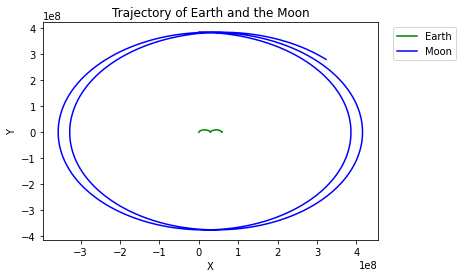

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
G = 6.67e-11
m1 = 5.972e24
m2 = 0.07346e24
r0 = 384.4e6

# Initial conditions
x10 = 0
x20 = 0
p10 = 0
p20 = 0
y10 = 0
y20 = 384.4e6
q10 = 1.022e3
q20 = 0

v0 = np.array([x10,x20,y10,y20,p10,p20,q10,q20])

# Defining the 8 first order ODEs
f = lambda t, y : np.array([
    y[4], 
    y[5],
    y[6],
    y[7],
    -(G*m2*(y[0]-y[2]))/r0**3,
    -(G*m2*(y[1]-y[3]))/r0**3,
    (G*m1*(y[0]-y[2]))/r0**3,
    (G*m1*(y[1]-y[3]))/r0**3
] )

# Time interval
t_span = (0, 5e6)
t_eval = np.linspace(0, 5e6, 5000000)

# Solving IVP with the initial conditions
sol = solve_ivp(f, t_span, v0, t_eval=t_eval)

# Plotting the 2 dimensional trajectory of the Earth and Moon
plt.plot(sol.y[0], sol.y[1], label = 'Earth', c='g')
plt.plot(sol.y[2], sol.y[3], label = 'Moon', c='b')
plt.title("Trajectory of Earth and the Moon")
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

### Part B (10 points)

The [Lorentz system](https://en.wikipedia.org/wiki/Lorenz_system) is a simplified model of atmospheric convection, which is one of the earliest systems investigated which exhibit [chaotic behavior](https://en.wikipedia.org/wiki/Chaos_theory).

\begin{equation}
\begin{cases}
dx/dt = \sigma( y - x)\\
dy/dt = x( \rho - z) - y\\
dz/dt = xy - \beta z
\end{cases}
\end{equation}

$x$ is the rate of convection, and $y$ and $z$ measure horizontal and vertical temperature variation.

You can use the parameters Lorentz used: $\sigma=10, \beta = 8/3, \rho = 28$.  
Run one simulation starting $x = y = z = 10$.  Run the simulation for $t\in [0,7]$.

Run another simulation starting at $y = z = 10$, and $x = 10.1$.  Run the simulation for $t \in [0,7]$.

Plot both solution trajectories in the $x,y$ plane (i.e. `plt(sol.y[0], sol.y[1],...`) using different colors (include labels, a title, and legend).  This system is chaotic, so the trajectories should start close and then get further apart.

---

*put any answers/discussion here*

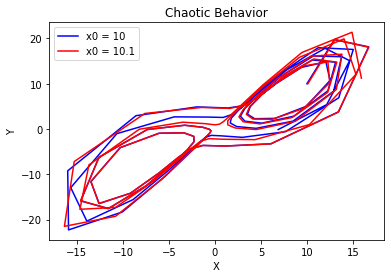

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
sigma = 10
beta = 8/3
rho = 28

# Simulation 1
# Initial conditions
x0 = 10
y0 = 10
z0 = 10

v01 = np.array([x0, y0, z0])

# Defining the three ODEs
f = lambda t, y : np.array([
    sigma*(y[1]-y[0]), 
    y[0]*(rho - y[2]) - y[1],
    y[0]*y[1] - beta*y[2]
    
] )

# Time interval
t_span = (0, 7)
t_eval = np.linspace(0, 7, 100)

# Solve IVP
sol1 = solve_ivp(f, t_span, v01, t_eval=t_eval)

# Simulation 2
# New Initial conditions
x0 = 10.1
y0 = 10
z0 = 10

v02 = np.array([x0, y0, z0])

# Solve IVP
sol2 = solve_ivp(f, t_span, v02, t_eval=t_eval)
   
# Plot the trajectories of both solutions    
plt.plot(sol1.y[0], sol1.y[1], label = 'x0 = 10', c='b')
plt.plot(sol2.y[0], sol2.y[1], label = 'x0 = 10.1', c='r')
plt.title("Chaotic Behavior")
plt.ylabel("Y")
plt.xlabel("X")
plt.legend()
plt.show()

## Problem 3 (10 points)

Use functionality from `scipy.sparse` to help illustrate your answers to the following questions.

In the [class materials on differentiation](https://caam37830.github.io/book/04_functions/differentiation.html), we defined `forward_diff_matrix` and `backward_diff_matrix`.  What vectors characterize the nullspace of each of these matrices (i.e. vectors `x` so that `D @ x = 0`)?

Give an interpretation (from calculus) of the vector `y` where `y` solves the linear system `D @ y = x`, where `D` is a finite-difference matrix.  What is the implication of the nullspace of `D` on solving this linear system?

Create a finite difference operator for the Laplacian $\Delta = \partial_x^2 + \partial_y^2$ where second-order differences are based on the stencil `[1, -2, 1]`.  What is the nullspace of this matrix?

---

*Your answer here.  You can create some code cells as well*

The null space of D consists of constant vectors where each element in the vector is the same such that when we apply the difference matrix to it, we get 0. 

There is an infinite number of vectors y that can solve this system since for any non-trivial solution y, we can add to it a constant vector (from the null space of D) and it will still give the same solution x

In [10]:
import numpy as np
import scipy.sparse as sparse
import sympy as sym

# The two functions are from the professor's notes
def forward_diff_matrix(n):
    """
    Generates a forward difference matrix to calculate derivatives
    """
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()


def backward_diff_matrix(n):
    """
    Generates a backward difference matrix to calculate derivatives
    """
    data = []
    i = []
    j = []
    for k in range(1,n):
        i.append(k)
        j.append(k)
        data.append(1)

        i.append(k)
        j.append(k-1)
        data.append(-1)
        
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()


# Second Derivative Difference Matrix (scheme [1, -2, 1])
D = forward_diff_matrix(100) @ backward_diff_matrix(100)

# Applying sparse.kron to get the second derivative in each direction
D2x = sparse.kron(sparse.eye(100), D).tocsr()
D2y = sparse.kron(D, sparse.eye(100)).tocsr()

# Laplacian
L = D2x + D2y
print(L.toarray())

[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -3.  1. ...  0.  0.  0.]
 [ 0.  1. -3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  0.  0.]]


I think the null space is matrices that are first order in x and/or y. I'm not sure how that really translates to vectors or matrix elements but I guess the elements of the matrix need to be at most first order in x/y or constant (all the same) such that their second derivatives are 0

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.

This assignment was extremely long and difficult as evidenced by the fact I wasn't able to finish problem 0 part C. It would be nice if other assignments were not as long or if they are, for us to have more time to work on them. 